<!---
MIT License

Copyright (c) 2020 Björn Plüster

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
-->

# Paypal Payment tracker
This Notebook allows you to input the raw html data from your Paypal Payments site and 
analyze it in any way you would like.

To use this yourself, simply copy the html data from your 
[Paypal transaction](https://www.paypal.com/myaccount/transactions/) page into ``payments.html`` and run all cells.
This notebook is fully offline and no data ever leaves your computer.

[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library is used for  HTML Parsing, while all visualization
is done using [Matplotlib](https://matplotlib.org/).

In [1]:
from bs4 import BeautifulSoup

file_name = "payments.html"
html_data = open(file_name, "r", encoding="UTF8").read()
table_soup = BeautifulSoup(html_data, "html.parser")
transactions = table_soup.findAll("div", {"class": "transactionDescriptionContainer"})
print(f"Loaded html data from {file_name}")
print(f'Found a total of {len(transactions)} transactions')

Loaded html data from payments.html
Found a total of 2 transactions


The first plot shows all transactions on a linear timeline. The next plot show the same data
but split up for every month.

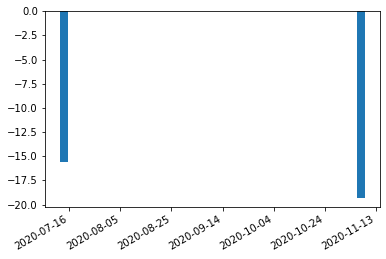

In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from transaction_utils import get_transaction_data

transaction_data = list(map(get_transaction_data, transactions))
dates = [date for _, _, date in transaction_data]
amounts = [amount for _, amount, _ in transaction_data]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.bar(dates, amounts, width=3)
plt.gcf().autofmt_xdate()
plt.show()

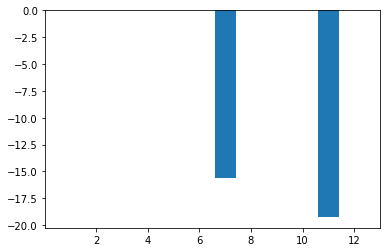

In [3]:
from functools import reduce

transaction_every_month = {i: [] for i in range(1,13)}
for (name, amount, date) in transaction_data:
    transaction_every_month[date.month].append((name, amount, date))

monthly_sums = {
    month: reduce(lambda a,b: a + b[1], transactions_in_month, 0)
    for month, transactions_in_month in transaction_every_month.items()
}

plt.bar(range(1,13), list(monthly_sums.values()))
plt.show()

__Overview of expenditures:__

In [4]:
total = sum(amounts)
sorted_dates = sorted(dates)
amount_days = (sorted_dates[-1] - sorted_dates[0] ).days
amount_per_day = total / amount_days

print(f"You spent a total of {-total:.2f}€ in {amount_days} days")
print(f"That's an average of {-amount_per_day:.2f}€ per day or {-amount_per_day*31:.2f}€ per month")

You spent a total of 34.87€ in 116 days
That's an average of 0.30€ per day or 9.32€ per month


In [5]:
def is_food_name(name):
    food_names = ["REWE", "EDEKA", "denn"]
    return any([food_name in name for food_name in food_names])

total_for_food = sum([amount for name, amount, _ in transaction_data if is_food_name(name)])

print(f"You spent a total of {-total_for_food:.2f}€ on food")

You spent a total of 19.28€ on food


In [6]:
from statistics import mean

times_between_purchases = [
    (sorted_dates[ i+1] -sorted_dates[i]).days for i in range(len(sorted_dates)-1)
]
average_time_between_purchases = mean(times_between_purchases) 

print(f"An average of {average_time_between_purchases:.2f} days passed between purchases with a max of {max(times_between_purchases)} days")
print(f"You made an average of {len(transactions) / amount_days:.2f} transactions per day")

An average of 116.00 days passed between purchases with a max of 116 days
You made an average of 0.02 transactions per day


__The following plots show a pie diagram of all places where money was spent and how much of all spending was done there.
 The second one only shows those >100€. All others are grouped into the categorie "others."__

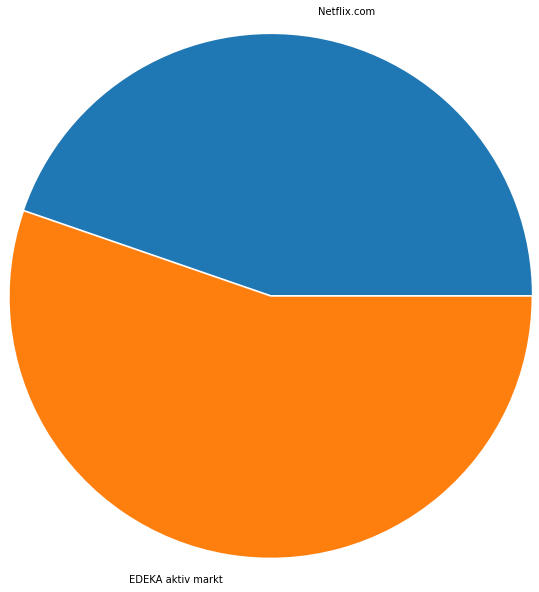

In [7]:
transaction_per_shop = dict.fromkeys([name for name,_,_ in transaction_data], 0.0)
for name, amount, _ in transaction_data:
    transaction_per_shop[name] -= amount

plt.pie(list(transaction_per_shop.values()),
        labels=list(transaction_per_shop.keys()),
        explode=[0.01]*len(transaction_per_shop),
        radius=3)
plt.show()

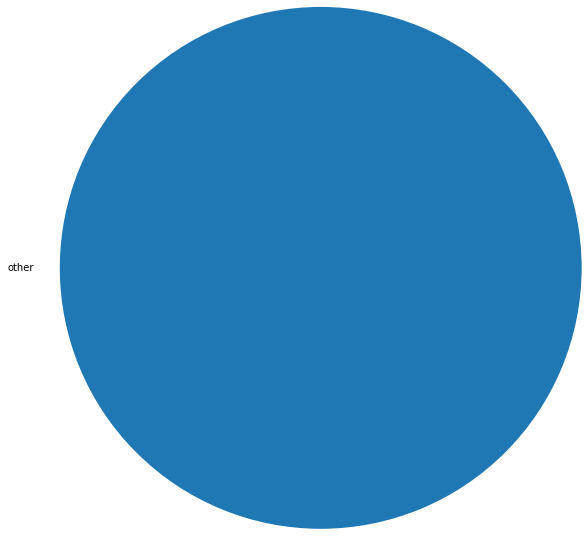

In [8]:
transaction_per_shop_over_100 = {"other": 0}
for name, value in transaction_per_shop.items():
    if value > 100:
        transaction_per_shop_over_100[name] = value
    else:
        transaction_per_shop_over_100["other"] += value

plt.pie(list(transaction_per_shop_over_100.values()),
        labels=list(transaction_per_shop_over_100.keys()),
        explode=[0.01]*len(transaction_per_shop_over_100),
        radius=3)
plt.show()
